# Compute volume change and ToE in density for IPSL-CM5A-LR r2i1p1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from netCDF4 import Dataset as open_ncfile
from netCDF4 import MFDataset
from maps_matplot_lib import zonal_2D, defVarmme, custom_div_cmap
from libToE import findToE
import datetime

In [2]:
# -- Data
list_h = glob.glob('/data/ericglod/Density_binning/IPSL_CM5/*historical_*.nc')
list_rcp = glob.glob('/data/ericglod/Density_binning/IPSL_CM5/*rcp85*.nc')
fhrcp = MFDataset(sorted(list_h+list_rcp))
list_hn = sorted(glob.glob('/data/ericglod/Density_binning/IPSL_CM5/*historicalNat*.nc'))
fhn = MFDataset(list_hn)

## Volume change 

In [6]:
# -- Read and define variables
varname = defVarmme('volume') ; v='V'

multStd = 2. # detect ToE at multStd std dev of histNat or PiControl
use_piC = False # Signal = (hist-histNat) + RCP8.5-average(histNat), noise = std(histNat)

lat = fhrcp.variables['latitude'][:]; latN = lat.size
lev = fhrcp.variables['lev'][:]; levN = lev.size
timN = 240
var = varname['var_zonal_w/bowl']
basinN = 4

varhrcp = fhrcp.variables[var][-15:-5, :, :, :]
varhn = fhn.variables[var][:, :, :, :]
var_change = np.ma.average(varhrcp, axis=0) - np.ma.average(varhn, axis=0)
bowl2 = fhrcp.variables['ptopsigma'][-15:-5,:,:]
bowl1 = fhn.variables['ptopsigma'][:,:,:]
bowl2 = np.ma.average(bowl2, axis=0)
bowl1 = np.ma.average(bowl1, axis=0)
labBowl = ['histNat', 'RCP8.5']

# Define variable properties
legVar = varname['legVar']
unit = varname['unit']
minmax = varname['minmax_zonal']
clevsm = varname['clevsm_zonal']

# == density domain ==
rhomin = 21
rhomid = 26
rhomax = 28
domrho = [rhomin, rhomid, rhomax]

valmask = 1e+20

In [7]:
var_change_p = var_change[2,:,:].squeeze()
var_change_a = var_change[1,:,:].squeeze()
var_change_i = var_change[3,:,:].squeeze()
bowl2_p = bowl2[2,:].squeeze(); bowl1_p = bowl1[2,:].squeeze()
bowl2_a = bowl2[1,:].squeeze(); bowl1_a = bowl1[1,:].squeeze()
bowl2_i = bowl2[3,:].squeeze(); bowl1_i = bowl1[3,:].squeeze()
var_mean_a = None
var_mean_p = None
var_mean_i = None

var_change_a[np.ma.nonzero(var_change_a>valmask/10)] = np.ma.masked
var_change_p[np.ma.nonzero(var_change_p>valmask/10)] = np.ma.masked
var_change_i[np.ma.nonzero(var_change_i>valmask/10)] = np.ma.masked

# Now mask points in the bowl
for ilat in range(latN):
    if np.ma.is_masked(bowl2_a[ilat]) == False :
        inda = np.ma.nonzero(bowl2_a[ilat]>=lev)
        var_change_a[inda,ilat] = np.ma.masked
    if np.ma.is_masked(bowl2_p[ilat]) == False :
        indp = np.ma.nonzero(bowl2_p[ilat]>=lev)
        var_change_p[indp,ilat] = np.ma.masked
    if np.ma.is_masked(bowl2_i[ilat]) == False :
        indi = np.ma.nonzero(bowl2_i[ilat]>=lev)
        var_change_i[indi,ilat] = np.ma.masked

# -- Create variable bundles
varPac = {'name': 'Pacific', 'var_change': var_change_p, 'var_mean': var_mean_p,
          'bowl1': bowl1_p, 'bowl2': bowl2_p, 'labBowl': labBowl}
varAtl = {'name': 'Atlantic', 'var_change': var_change_a, 'var_mean': var_mean_a,
          'bowl1': bowl1_a, 'bowl2': bowl2_a, 'labBowl': labBowl}
varInd = {'name': 'Indian', 'var_change': var_change_i, 'var_mean': var_mean_i,
          'bowl1': bowl1_i, 'bowl2': bowl2_i, 'labBowl': labBowl}


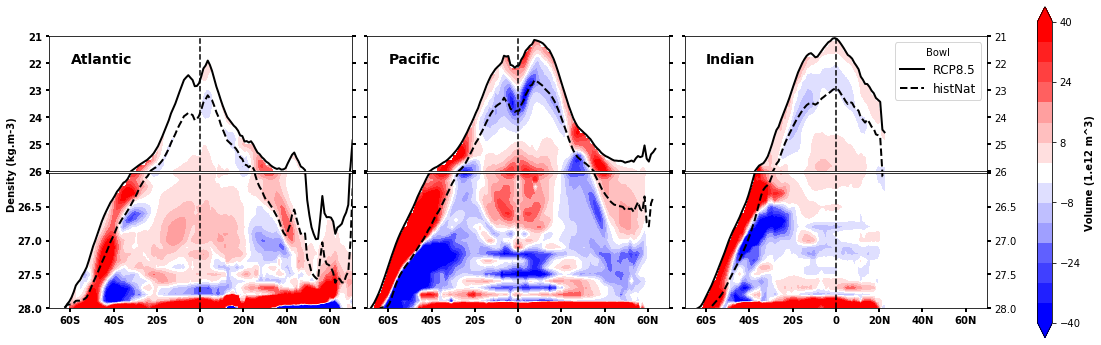

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,5))

levels = np.linspace(-40,40,16)#np.arange(-40,40.5,4)#(minmax[0], minmax[1], minmax[2])
cmap = custom_div_cmap() 

cnplot = zonal_2D(plt, 'total_mme', axes[0, 0], axes[1, 0], 'left', lat, lev, varAtl, domrho, cmap, levels, clevsm)

cnplot = zonal_2D(plt, 'total_mme', axes[0, 1], axes[1, 1], 'mid', lat, lev, varPac, domrho, cmap, levels, clevsm)

cnplot = zonal_2D(plt, 'total_mme', axes[0, 2], axes[1, 2], 'right', lat, lev, varInd, domrho, cmap, levels, clevsm)

plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.04, right=0.86)

cb = plt.colorbar(cnplot[0], ax=axes.ravel().tolist(), ticks=levels[::3], fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s (%s)' % (legVar, unit), fontweight='bold')

name = 'IPSL-CM5A-LR-r2i1p1_rcp85_meanhistNat'
plotTitle = '%s changes %s' %(legVar, name)
plotName = name + '_' + legVar
figureDir = 'models/zonal_ys/rcp85-histNat/'

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

plt.suptitle(plotTitle, fontweight='bold', fontsize=14, verticalalignment='top')
plt.figtext(.006,.4,'Density (kg.m-3)',rotation='vertical',horizontalalignment='left',fontweight='bold')

plt.savefig('/home/ysilvy/figures/'+figureDir+plotName+'.png', bbox_inches='tight')

## Time of Emergence

In [29]:
iniyear = 1860
finalyear = 2100
deltay = 10.

model = {'name':'IPSL-CM5A-LR'  ,'props':[6,3,11,156], 'picontrol':[1000],'correctFile':[0,0,0],
          'file_end_hist':'v20111119', 'file_end_histNat':'v20120430',
          'hist-rcp85':['r2i1p1','r3i1p1','r4i1p1']}

# Index of common time interval
tstart = model['props'][2]
tend = model['props'][3]

# Read var histNat
varhn_a = fhn.variables[var][:,1,:,:].squeeze()
varhn_p = fhn.variables[var][:,2,:,:].squeeze()
varhn_i = fhn.variables[var][:,3,:,:].squeeze()

# Compute std of histNat
stdvarhn_a = np.ma.std(varhn_a, axis=0)
stdvarhn_p = np.ma.std(varhn_p, axis=0)
stdvarhn_i = np.ma.std(varhn_i, axis=0)

# Compute time average of the whole histNat series (signal over projection = RCP - mean(histNat))
meanvarhn_a = np.ma.mean(varhn_a, axis=0)
meanvarhn_p = np.ma.mean(varhn_p, axis=0)
meanvarhn_i = np.ma.mean(varhn_i, axis=0)

# Reorganise i,j dims in single dimension data (speeds up loops)
varnoise_a = np.reshape(stdvarhn_a, (levN*latN))
varnoise_p = np.reshape(stdvarhn_p, (levN*latN))
varnoise_i = np.reshape(stdvarhn_i, (levN*latN))

# Initialize toe for each basin (density, lat)
toe1_a = np.ma.masked_all((levN,latN))
toe1_p = np.ma.masked_all((levN,latN))
toe1_i = np.ma.masked_all((levN,latN))
toe2_a = np.ma.masked_all((levN,latN))
toe2_p = np.ma.masked_all((levN,latN))
toe2_i = np.ma.masked_all((levN,latN))
# Initialize output variable
varToE1 = np.ma.masked_all((basinN,levN,latN)) # (>1std) (basin,density,latitude)
varToE2 = np.ma.masked_all((basinN,levN,latN)) # (>2std)
varsignal_end = np.ma.masked_all((basinN,levN,latN)) # Save signal (last 5 years)

# Read var hist + rcp85
varhrcp_a = fhrcp.variables[var][tstart:tend+95,1,:,:].squeeze()
varhrcp_p = fhrcp.variables[var][tstart:tend+95,2,:,:].squeeze()
varhrcp_i = fhrcp.variables[var][tstart:tend+95,3,:,:].squeeze()

# Initialize and fill var_signal for each basin (timN, density, latitude)
varsignal_a = np.ma.masked_all((timN,levN,latN))
varsignal_p = np.ma.masked_all((timN,levN,latN))
varsignal_i = np.ma.masked_all((timN,levN,latN))

varsignal_a = varhrcp_a-meanvarhn_a
varsignal_p = varhrcp_p-meanvarhn_p
varsignal_i = varhrcp_i-meanvarhn_i

# Save signal
varsignal_end[1,:,:] = np.ma.average(varsignal_a[-5:,:,:],axis=0)
varsignal_end[2,:,:] = np.ma.average(varsignal_p[-5:,:,:],axis=0)
varsignal_end[3,:,:] = np.ma.average(varsignal_i[-5:,:,:],axis=0)

# Reorganise i,j dims in single dimension data (speeds up loops)
varsignal_a = np.reshape(varsignal_a, (timN, levN*latN))
varsignal_p = np.reshape(varsignal_p, (timN, levN*latN))
varsignal_i = np.reshape(varsignal_i, (timN, levN*latN))

# Compute ToE as last date when diff hist+RCP - histNat is larger than mult * stddev
varToE2[1,:,:] = np.reshape(findToE(varsignal_a, varnoise_a, multStd),(levN,latN)) +iniyear
varToE2[2,:,:] = np.reshape(findToE(varsignal_p, varnoise_p, multStd),(levN,latN)) +iniyear
varToE2[3,:,:] = np.reshape(findToE(varsignal_i, varnoise_i, multStd),(levN,latN)) +iniyear
varToE1[1,:,:] = np.reshape(findToE(varsignal_a, varnoise_a, 1),(levN,latN)) +iniyear
varToE1[2,:,:] = np.reshape(findToE(varsignal_p, varnoise_p, 1),(levN,latN)) +iniyear
varToE1[3,:,:] = np.reshape(findToE(varsignal_i, varnoise_i, 1),(levN,latN)) +iniyear

# Mask points because when calculating ToE, masked points (e.g. bathy, no data) are set to 240 (=no emergence)
idx=np.argwhere(varsignal_end.mask==True)
varToE2[idx[:,0],idx[:,1],idx[:,2]] = np.ma.masked
varToE1[idx[:,0],idx[:,1],idx[:,2]] = np.ma.masked

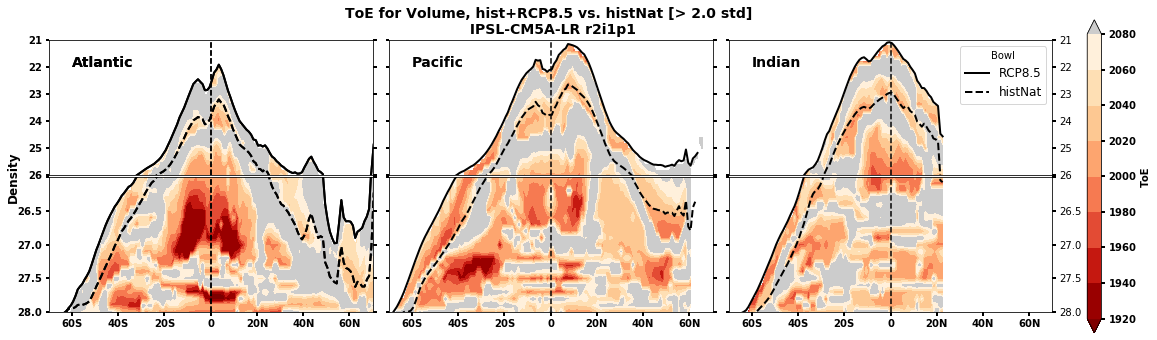

In [31]:
# == Prepare plot
min = 1920 # Start year for colorbar
deltat=20

# -- Mask points above RCP8.5/1%CO2 bowl
for ilat in range(len(lat)):
    if np.ma.is_masked(bowl2[1,ilat]) == False :
        inda = np.ma.nonzero(bowl2[1,ilat]>=lev)
        varToE2[1,inda,ilat] = np.ma.masked
    if np.ma.is_masked(bowl2[2,ilat]) == False :
        indp = np.ma.nonzero(bowl2[2,ilat]>=lev)
        varToE2[2,indp,ilat] = np.ma.masked
    if np.ma.is_masked(bowl2[3,ilat]) == False :
        indi = np.ma.nonzero(bowl2[3,ilat]>=lev)
        varToE2[3,indi,ilat] = np.ma.masked

# -- Create variable bundles
varAtl = {'name': 'Atlantic', 'ToE': varToE2[1,:,:], 'bowl2': bowl2[1,:], 'bowl1': bowl1[1,:], 'labBowl': labBowl}
varPac = {'name': 'Pacific', 'ToE': varToE2[2,:,:], 'bowl2': bowl2[2,:], 'bowl1': bowl1[2,:], 'labBowl': labBowl}
varInd = {'name': 'Indian', 'ToE': varToE2[3,:,:], 'bowl2': bowl2[3,:], 'bowl1': bowl1[3,:], 'labBowl': labBowl}

# -- Plot

lat2d, density2d = np.meshgrid(lat,lev)

# Date
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(17,5))

minmax = [min, finalyear-20 +0.1, deltat]
unit = 'ToE'
cmap = 'OrRd_r'
levels = np.arange(minmax[0], minmax[1], minmax[2])

# -- Atlantic
cnplot = zonal_2D(plt, 'ToE', axes[0, 0], axes[1, 0], 'left', lat, lev, varAtl, domrho, cmap, levels)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# -- Add colorbar
cb = fig.colorbar(cnplot[1],ax=axes.ravel().tolist(), ticks = levels, fraction=0.015, shrink=2.0, pad=0.05)
cb.set_label('%s' % (unit,), fontweight='bold')
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontweight='bold')
cb.ax.yaxis.set_tick_params(which='major',width=2)

# -- Pacific
cnplot = zonal_2D(plt, 'ToE', axes[0, 1], axes[1, 1], 'mid', lat, lev, varPac, domrho, cmap, levels)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# -- Indian
cnplot = zonal_2D(plt, 'ToE', axes[0, 2], axes[1, 2], 'right', lat, lev, varInd, domrho, cmap, levels)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# -- Repeat Atlantic
cnplot = zonal_2D(plt, 'ToE', axes[0, 0], axes[1, 0], 'left', lat, lev, varAtl, domrho, cmap, levels)
cnplot[0].cmap.set_over('0.8')
cnplot[1].cmap.set_over('0.8')

# -- Contours
# for i in range(3):
#     cnt1 = axes[0,i].contour(lat2d,density2d,medianToE[i+1,:,:],levels=levels[::2],linewidths=0.5,colors='k')
#     cnt1_b = axes[0,i].contour(lat2d,density2d,medianToE[i+1,:,:],levels=[2020],linewidths=2,colors='k')           
#     cnt2 = axes[1,i].contour(lat2d,density2d,medianToE[i+1,:,:],levels=levels[::2],linewidths=0.5,colors='k')
#     cnt2_b = axes[1,i].contour(lat2d,density2d,medianToE[i+1,:,:],levels=[2020],linewidths=2,colors='k')

plt.subplots_adjust(hspace=.012, wspace=0.05, left=0.04, right=0.86)

name = 'hist+RCP8.5 vs. histNat'
plotName = 'IPSLCM5ALR_r2i1p1_ToE_'+legVar+'_rcp85vshistNat_'+str(multStd)+'std'
plotTitle = 'ToE for ' + legVar + ', ' + name + ' [> ' + str(multStd) + ' std] \n IPSL-CM5A-LR r2i1p1'
axes[0,1].set_title(plotTitle, fontweight='bold', fontsize=14)
plt.figtext(.006,.5,'Density',rotation='vertical',horizontalalignment='left',fontsize=12,fontweight='bold',va='center')
    
plt.savefig('/home/ysilvy/figures/models/zonal_ys/ToE/rcp85_histNat/'+plotName+'.png', bbox_inches='tight')    

In [7]:
# Reconstruct volume from thickness of isopycnals in 4D file
thick = fh.variables['isonthickg'][:,:,:,:]/1.e03
targetGrid = '/home/ysilvy/Density_bining/Yona_analysis/data/170224_WOD13_masks.nc'
# Target horizonal grid
gridFile_f  = open_ncfile(targetGrid,'r')
maskg       = gridFile_f.variables['basinmask3'][:]
areai = gridFile_f.variables['basinmask3_area'][:] #(latitude,longitude), in km2
Nii     = areai.shape[1]
Nji     = areai.shape[0]
N_s = thick.shape[1]
timeN = thick.shape[0]
areaisig = np.tile(np.ma.reshape(areai,Nii*Nji), (N_s,1))
areaisig = np.ma.reshape(areaisig,[N_s,Nji,Nii])
areaisig = np.repeat(areaisig[np.newaxis,:,:,:],timeN,axis=0)
maski       = maskg.mask ; # Global mask
# Regional masks
maskAtl = maski*1 ; maskAtl[...] = True
idxa = np.argwhere(maskg == 1).transpose()
maskAtl[idxa[0],idxa[1]] = False
maskPac = maski*1 ; maskPac[...] = True
idxp = np.argwhere(maskg == 2).transpose()
maskPac[idxp[0],idxp[1]] = False
maskInd = maski*1 ; maskInd[...] = True
idxi = np.argwhere(maskg == 3).transpose()
maskInd[idxi[0],idxi[1]] = False

# Compute total volume as thickness*area of each cell
vol = thick*(1-(thick.mask).astype(int))*areaisig
print(np.ma.sum(vol)/1.e09) # In km3

# Mask with basin masks
thicki = thick*1.
thicki.mask = maski
thickia = thick*1.
thickia.mask = maskAtl
thickip = thick*1.
thickip.mask = maskPac
thickii = thick*1.
thickii.mask = maskInd
# Compute zonal volume
volz  = np.ma.sum(thicki *(1- (thicki.mask).astype(int))*areaisig, axis=3)
volza = np.ma.sum(thickia*(1- (thickia.mask).astype(int))*areaisig, axis=3)
volzp = np.ma.sum(thickip*(1- (thickip.mask).astype(int))*areaisig, axis=3)
volzi = np.ma.sum(thickii*(1- (thickii.mask).astype(int))*areaisig, axis=3)
print(np.ma.sum(volz)/1.e09)

# Read variables
lat = fh.variables['latitude'][:]
density = fh.variables['lev'][:]

basinN=4
latN = len(lat)
densityN = len(density)

isonvol = np.ma.stack([volz,volza,volzp,volzi],axis=0)
isonvol[isonvol==0]=np.ma.masked

1.2327514393249774
1.2327514393249777
